### AIIE 2025 Google Generative AI Model: "gemini-1.5-flash-001"

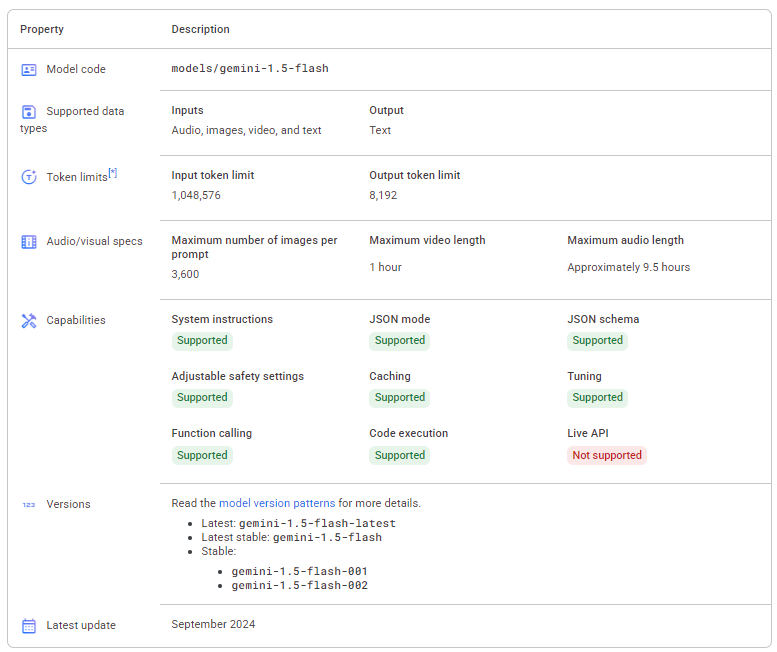

In [1]:
#Installing libraries useful for reading files, PyPDF2 for PDFs, python-docx for .docx
!pip install PyPDF2 python-docx google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 18.5 MB/s eta 0:00:00


In [2]:
import google.generativeai as genai
import os
import textwrap
from google.colab import userdata, files # Import files for document upload
import PyPDF2 # For PDF files
import docx # For .docx Word files
from IPython.display import display, Markdown, clear_output # For better Colab output

# from google import genai
# from google.genai import types
# from PIL import Image
# from io import BytesIO
# import base64
# from google.colab import userdata
# import os

# # Libraries for document parsing
# import PyPDF2 # For PDF files
# import docx # For .docx Word files


In [3]:
# It's good practice to get your API key securely, as you're doing with userdata.
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

In [4]:
# Initialize the Gemini client
client = genai.configure(api_key=GOOGLE_API_KEY)

In [5]:
def extract_text_from_pdf(pdf_path):
    """Extracts text from a PDF file."""
    text = ""
    try:
        with open(pdf_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            for page_num in range(len(reader.pages)):
                text += reader.pages[page_num].extract_text() or ""
        return text
    except PyPDF2.utils.PdfReadError:
        print(f"Error: Could not read PDF file '{pdf_path}'. It might be corrupted or encrypted.")
        return None
    except Exception as e:
        print(f"An error occurred while reading PDF '{pdf_path}': {e}")
        return None

def extract_text_from_docx(docx_path):
    """Extracts text from a .docx (Word) file."""
    text = ""
    try:
        document = docx.Document(docx_path)
        for paragraph in document.paragraphs:
            text += paragraph.text + "\n"
        return text
    except Exception as e:
        print(f"An error occurred while reading DOCX '{docx_path}': {e}")
        return None

def extract_text_from_plain_text(txt_path):
    """Extracts text from a plain text file."""
    try:
        with open(txt_path, 'r', encoding='utf-8') as file:
            return file.read()
    except UnicodeDecodeError:
        print(f"Error: Could not decode text file '{txt_path}' with UTF-8. Trying with 'latin-1'.")
        with open(txt_path, 'r', encoding='latin-1') as file:
            return file.read()
    except Exception as e:
        print(f"An error occurred while reading text file '{txt_path}': {e}")
        return None


In [6]:
# --- 3. Function to Handle Document Upload and Extraction ---
def upload_and_process_document():
    uploaded_files = files.upload()
    if not uploaded_files:
        print("No file uploaded.")
        return None, None

    file_name = next(iter(uploaded_files)) # Get the name of the first uploaded file
    file_path = file_name

    print(f"Processing uploaded file: {file_name}")

    file_extension = os.path.splitext(file_name)[1].lower()

    document_content = None
    if file_extension == '.pdf':
        document_content = extract_text_from_pdf(file_path)
    elif file_extension == '.docx':
        document_content = extract_text_from_docx(file_path)
    elif file_extension in ['.txt', '.md', '.csv']: # Add other text-based extensions if needed
        document_content = extract_text_from_plain_text(file_path)
    else:
        print(f"Error: Unsupported file type: {file_extension}")
        print("Supported types: .pdf, .docx, .txt, .md, .csv")
        return None, None

    if document_content:
        # --- IMPORTANT: Token Limit Warning and Truncation ---
        # Gemini models have token limits (e.g., 128k for 1.5-flash).
        # Very long documents might exceed this limit.
        # For simplicity, we'll truncate. For production-grade large documents,
        # you'd need a RAG system (chunking, embeddings, vector search).
        MAX_DOC_CHARS = 100000 # Adjust based on model's context window (roughly 1 char ~ 0.25 tokens)
                               # 100k chars is approx 25k tokens. gemini-1.5-flash has 128k tokens.
        if len(document_content) > MAX_DOC_CHARS:
            print(f"Warning: Document content is very large ({len(document_content)} chars).")
            print(f"Truncating to first {MAX_DOC_CHARS} characters to fit model limits.")
            document_content = document_content[:MAX_DOC_CHARS]
        else:
            print(f"Document content size: {len(document_content)} characters.")

    return document_content, file_name


In [7]:
# --- Helper Functions for Text Extraction ---

def extract_text_from_pdf(pdf_path):
    """Extracts text from a PDF file."""
    text = ""
    try:
        with open(pdf_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            for page_num in range(len(reader.pages)):
                text += reader.pages[page_num].extract_text() or "" # Handle empty pages
        return text
    except PyPDF2.utils.PdfReadError:
        print(f"Error: Could not read PDF file '{pdf_path}'. It might be corrupted or encrypted.")
        return None
    except Exception as e:
        print(f"An error occurred while reading PDF '{pdf_path}': {e}")
        return None

def extract_text_from_docx(docx_path):
    """Extracts text from a .docx (Word) file."""
    text = ""
    try:
        document = docx.Document(docx_path)
        for paragraph in document.paragraphs:
            text += paragraph.text + "\n"
        return text
    except Exception as e:
        print(f"An error occurred while reading DOCX '{docx_path}': {e}")
        return None

def extract_text_from_plain_text(txt_path):
    """Extracts text from a plain text file."""
    try:
        with open(txt_path, 'r', encoding='utf-8') as file:
            return file.read()
    except UnicodeDecodeError:
        print(f"Error: Could not decode text file '{txt_path}' with UTF-8. Trying with 'latin-1'.")
        with open(txt_path, 'r', encoding='latin-1') as file:
            return file.read()
    except Exception as e:
        print(f"An error occurred while reading text file '{txt_path}': {e}")
        return None

def get_document_text(file_path):
    """
    Determines file type and extracts text accordingly.
    Returns the extracted text or None if an error occurs.
    """
    if not os.path.exists(file_path):
        print(f"Error: File not found at '{file_path}'")
        return None

    file_extension = os.path.splitext(file_path)[1].lower()

    if file_extension == '.pdf':
        print(f"Extracting text from PDF: {file_path}")
        return extract_text_from_pdf(file_path)
    elif file_extension == '.docx':
        print(f"Extracting text from DOCX: {file_path}")
        return extract_text_from_docx(file_path)
    elif file_extension in ['.txt', '.md', '.csv', '.html']: # Add other text-based extensions
        print(f"Extracting text from plain text file: {file_path}")
        return extract_text_from_plain_text(file_path)
    else:
        print(f"Error: Unsupported file type: {file_extension}")
        print("Supported types: .pdf, .docx, .txt, .md, .csv, .html")
        return None


In [9]:
# --- 4. Main Chatbot Logic with Document Context ---
if __name__ == "__main__":
    clear_output(wait=True) # Clear previous output in Colab
    print("Welcome to the Document Query Chatbot!")
    print("First, please upload the document you want to query.")
    print("Supported formats: PDF, DOCX, TXT, MD, CSV.")
    print("-" * 40)

    queried_document_content = None
    queried_document_name = None

    while queried_document_content is None:
        queried_document_content, queried_document_name = upload_and_process_document()
        if queried_document_content is None:
            print("\nDocument processing failed or no document uploaded. Please try again.")

    clear_output(wait=True) # Clear upload messages
    print(f"Successfully loaded '{queried_document_name}' for querying.")
    print("You can now ask questions about the document.")
    print("Type 'exit' to quit the chat.")
    print("-" * 40)

    # Initialize the Generative Model and Start a Chat Session
    # Using a model with a larger context window is better for document querying.
    model = genai.GenerativeModel('gemini-1.5-flash-001') # Or 'gemini-1.5-pro-001' for more powerful context
    chat = model.start_chat(history=[]) # History for general conversation

    # --- Chat Loop ---
    while True:
        user_message = input("You (ask about document): ")

        if user_message.lower() == 'exit':
            print("Chatbot: Goodbye!")
            break

        # --- IMPORTANT: Augmenting the user's query with document context ---
        # We prepend the document content to the user's query for each turn.
        # This acts as the "context" for the LLM to answer from.
        prompt_with_context = (
            f"Here is a document: \"\"\"{queried_document_content}\"\"\"\n\n"
            f"Based *only* on the provided document, answer the following question: {user_message}"
        )

        print("Chatbot: Thinking...")
        try:
            # Send the augmented prompt to Gemini
            bot_response = chat.send_message(prompt_with_context)

            print("\nChatbot:", textwrap.fill(bot_response.text, width=80))
            print("-" * 40)

        except Exception as e:
            print(f"Chatbot: Sorry, I encountered an error: {e}")
            print("This might be due to exceeding token limits or an API issue.")
            print("Please try a shorter query or type 'exit' to quit.")
            print("-" * 40)

Successfully loaded 'Isaac Lasso Younes_Cybersecurity_In Progress (1).pdf' for querying.
You can now ask questions about the document.
Type 'exit' to quit the chat.
----------------------------------------
You (ask about document): What would you improve in this document
Chatbot: Thinking...

Chatbot: Here are some suggestions for improvement in the provided document:
**Formatting and Readability:**  * **Consistent Formatting:** The document uses
a mix of bolding, capitalization, and spacing.  Standardize the formatting for
better visual appeal and clarity. For example, use bold for headings, capitalize
only proper nouns in titles, and use consistent spacing between sections. *
**Whitespace and Line Breaks:**  Break up large blocks of text with more line
breaks and white space to improve readability. * **Font Consistency:** Stick to
one font family throughout the document.  **Content and Clarity:**  * **Quantify
Achievements:** While you mention "95% satisfaction" and "$200 raised," tr